In [6]:
import datetime
import pandas as pd
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from warnings import simplefilter
simplefilter(action="ignore",category=FutureWarning)

'''读取科创板开板以来的收盘价数据'''
data=pd.read_csv('STARDATA.csv').set_index('date')
data.index=pd.to_datetime(data.index.astype(str),format='%Y%m%d')

'''处理数据格式中问题，将首日前一日的0去掉，将0替换成nan'''
data=data.replace(0,np.nan)

'''读股票信息，包含每只科创板股票的代码、名称、行业、流通市值、总市值、流通股本、PE。其中流通股本在后续限制仓位规模时会起作用'''
info=pd.read_csv('Stockinfo.csv')
info['code']=info['code'].astype(str)

**作图**  
首先对科创板的所有股票的交易价格作图，大致对市场的价格波动有初步印象

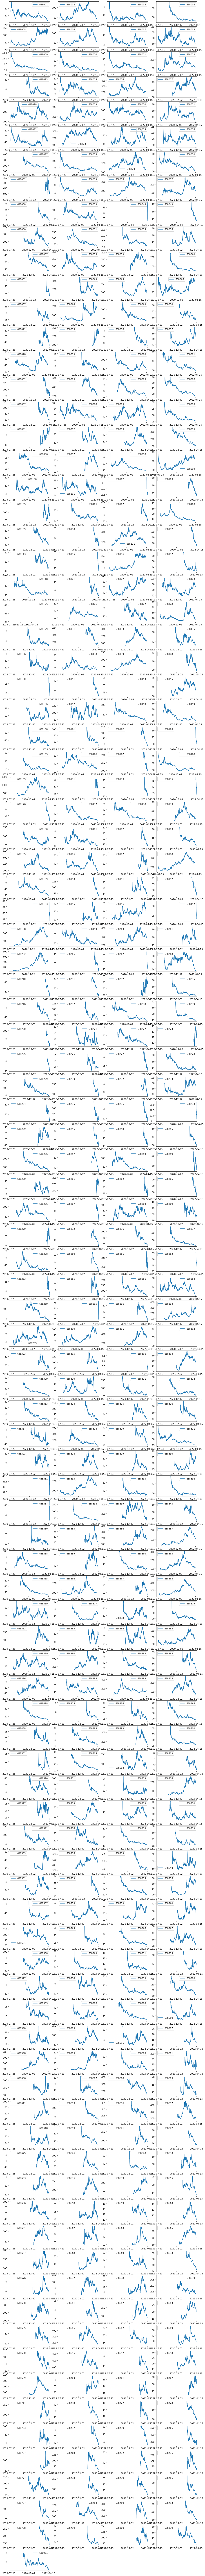

done


In [7]:
'''作图'''
k=1
plt.figure(1,figsize=(15,210))

for i in data.columns:
    fig=plt.subplot(103,4,k)
    k+=1
    plot1=plt.plot(data[i])
    plt.legend([i])
    plt.xticks(data[i].index[(range(1,len(data[i]),round(len(data[i])/2)-1))])

# plt.savefig('STARprice.png') 
plt.show()
print('done')

# 第一部分：搜索科创板股票之间的协整关系
* **两条时间序列之间是否存在协整关系**  
两条时间序列的协整关系，可以利用OLS以一支股票价格序列为自变量，另一只价格序列为因变量拟合，检测对应模型产生的残差是否平稳即可。利用Augmented Dickey-Fuller检验残差的平稳性。
* **搜索科创板股票之间的协整关系**  
科创板自2019年7月开板，市场规模从开板时的7支扩大到目前的409支。由于股票的上市存续时间存在差异，首先计算409支股票的上市存续时间，再对存续时间进行从短到长排序（生成代码中的trade_info DataFrame）。按照存续时间从短到长进行循环搜索，也就是在trade_info里，从上到下进行遍历股票，遍历时逐个搜索当前股票下方所有股票和当前股票之间是否存在协整关系。  
* **相关类或函数**  
cointegration_search--搜索科创板所有股票是否存在协整关系  
test_cointegration--检测两只股票是否存在显著的协整关系  
draw_date_coloured_scatterplot--绘制两只股票价格的散点图  
coin_viewer--查看协整对的信息，包括绘制描述两只股票信息的散点图和股价图，并罗列相关信息

In [24]:
def cointegration_search(trade_info,data,T,p_set,save_name):
    '''
    搜索科创板所有股票是否存在协整关系
    
    参数：
    trade_info -- 为输入的股票交易天数表，以便从后往前遍历，搜索协整关系
    data -- 为科创板全市场交易信息
    T -- 股票进入搜索的最短交易天数，如设为20，则目前新上市交易天数少于20天的股票不会进入搜索范围
    p_set -- 设置残差ADF检验通过的阈值
    返回值：
    coin_list -- 记录所有有协整关系的股票，['x' 股票代码1, 'y' 股票代码, 'p_value' 残差ADF检验p值, 'ratio' 对冲比率,'length' 协整关系的时间跨度
    '''

    coin_list = pd.DataFrame(columns=['x', 'y', 'p_value', 'ratio','length'])
    search_span = trade_info[trade_info['days'] >= T]
    y_codes = search_span['code'].reset_index(drop=True)
    for i, r in search_span.iterrows():
        x_code = r['code']
        T_span = r['days']
        x = data[x_code][-T_span:-1]
        y_codes = y_codes[1::].reset_index(drop=True)
        for j in y_codes:
            y = data[j][-T_span:-1]
            name = [x_code, j]
            result = test_cointegration(name, x, y, p_set)
            if result[0] == True:
                # print(name)
                coin_list = coin_list.append({'x': x_code, 'y': j, 'p_value': result[2], 'ratio': result[1].params[1],
                                              'length':len(x)},
                                             ignore_index=True)
    print('search done')
    coin_list.to_csv(save_name+'.csv')
    return coin_list


def test_cointegration(name,x,y,p_set):
    '''
    检测两只股票是否存在显著的协整关系
    
    参数：
    name -- 两只股票代码组合的list
    x -- 作为自变量的股票价格序列
    y -- 作为因变量的股票价格序列
    p_set -- 假设检验的致信水平为95%时，作为是否显著的阈值，常规统计为0.05，即p值小于0.05即代表拒绝原假设，也就是残差平稳，即x和y协整，
             这里最初的想法是可以调节判断是否显著的阈值，灵活调节置信水平。
    返回值：
    真或假，OLS拟合的模型， ADF检验的p值
    '''
    X=sm.add_constant(x)
    res=sm.OLS(y,X).fit()
    residual = res.resid
    adf_test = ts.adfuller(residual)
    if adf_test[1]<p_set:
        # print('p_calue:', adf_test[1])
        # draw_date_coloured_scatterplot(name, x, y)
        # plt.plot(residual)
        # plt.xticks(rotation=45)
        # plt.show()
        return True,res,adf_test[1]
    else:
        # print('p_calue:', adf_test[1])
        return False,res,adf_test[1]


def draw_date_coloured_scatterplot(name,x, y):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the
    changing relationship between the sets of prices
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(x)
    colour_map = plt.cm.get_cmap('YlOrRd')
    colours = np.linspace(0.1, 1, plen)

    # Create the scatterplot object
    scatterplot = plt.scatter(
        x, y,
        s=30, c=colours, cmap=colour_map,
        edgecolor='k', alpha=0.8
    )

    # Add a colour bar for the date colouring and set the
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in x[::plen // 9].index]
    )
    plt.xlabel(name[0])
    plt.ylabel(name[1])
    plt.show()
    

def coin_viewer(codea,codeb,data,info):
    '''查看任意一组协整对的散点图和残差图'''
    '''plot scatter'''
    t=min(len(data[codea][data[codea].notna()]),len(data[codeb][data[codeb].notna()]))
    x=data[codea][-t::]
    y=data[codeb][-t::]
    draw_date_coloured_scatterplot([codea,codeb],x,y)
    
    '''plot price and resid'''
    '''price'''
    plt.figure(1,figsize=(15,6))
    X=sm.add_constant(x)
    model=sm.OLS(y,X).fit()
    res=model.resid
    fig1=plt.subplot(1,2,1)
    plt.plot(x)
    plt.plot(y)
    plt.legend([codea,codeb])
    plt.title('stock price')
    plt.xticks(rotation=45)
    '''resid'''
    fig2=plt.subplot(1,2,2)
    plt.plot(res)
    plt.legend([codea+' '+codeb])
    plt.xticks(rotation=45)
    plt.title('residual')
    plt.show()
    
    '''显示两只股票的基本信息'''
    print(codea)
    a_info=info[(info['code']==codea)|(info['code']==codeb)].transpose()
    print(a_info)
    
    '''两支股票标准化后的图像'''
    x_std = (x - np.mean(x)) / np.std(x)
    y_std = (y - np.mean(y)) / np.std(y)
    
    plt.figure(1,figsize=(15,6))
    plt.plot(x_std)
    plt.plot(y_std)
    plt.legend([codea,codeb])
    plt.title('standarlized stock price')
    plt.xticks(rotation=45)
    plt.show()
    return model
    
# m1=coin_viewer('688010','688009',data,info)


以下代码框测试两只股票的协整性  
利用688001和688002两只股票价格序列进行测试，测试发现：2019年7月22日到2022年7月22日，残差平稳性不显著，即两只股票价格不存在协整关系。但根据散点图可以看出，分别在2019年7月22日到2020年7月22日和2021年8月25日到2022年4月7日两个时间区间内，两只股票价格波动呈线性，可能在两个时间范围内分别存在协整关系。  
**以两只股票的协整关系可能在时间上是不稳定的，可能存在一个时间范围两者协整，而之后两者不再协整；或者在一个时间区间的几个子区间**  

adf_test:2019年7月22日到2022年7月22日-->不显著  
adf_test:2019年7月22日到2019年11月1日-->显著 p-value 0.04416843751659719

OLS信息：                             OLS Regression Results                            
Dep. Variable:                 688002   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1202.
Date:                Tue, 10 May 2022   Prob (F-statistic):           1.61e-44
Time:                        16:57:13   Log-Likelihood:                -142.06
No. Observations:                  69   AIC:                             288.1
Df Residuals:                      67   BIC:                             292.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0509      1.480     -1.386  

/var/folders/1p/b72l5fpn1gx7sznvkyrvcyk40000gn/T/ipykernel_25486/2037418778.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.ax.set_yticklabels(


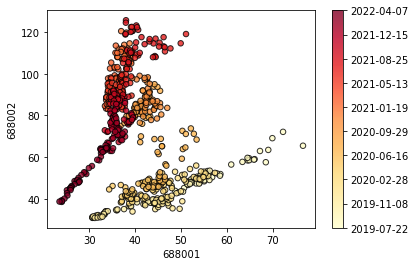

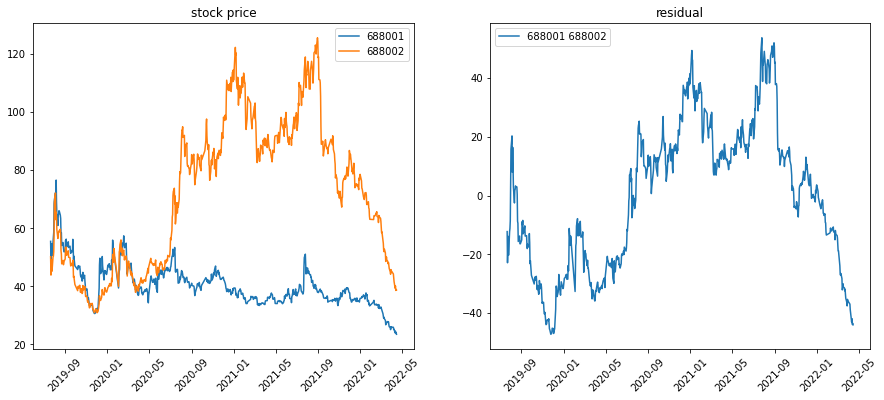

688001
                    260            387
code             688001         688002
name               华兴源创           睿创微纳
industry           信息技术           信息技术
cmv        1203050506.0  10476385517.0
mv        10488156304.0  18171007575.0
pe               33.405         39.401
csc            50400105      257152320


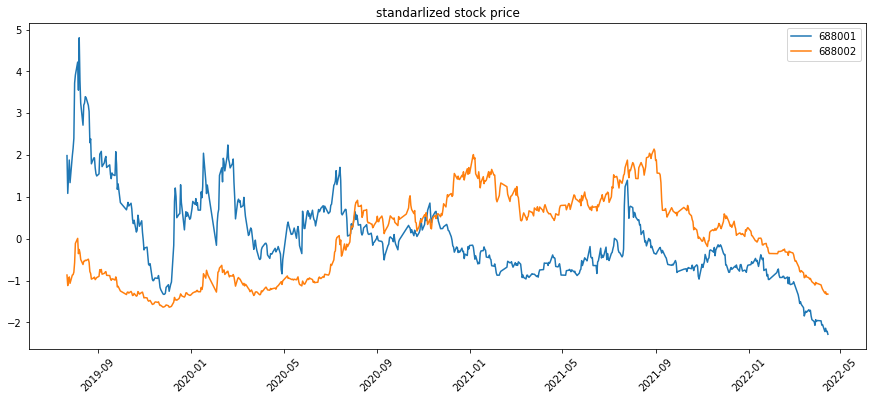

In [37]:
'''测试test_cointegration函数,测试coin_viewer'''

x,y=data['688001'],data['688002']
name1=['688001','688002']
x1=data['688001']['2019-07-22':'2019-11-01']
y1=data['688002']['2019-07-22':'2019-11-01']
print('OLS信息：',test1[1].summary())
print('是否协整：',test1[0],'ADF检验的p值：',test1[2])
test1=test_cointegration(name1,x1,y1,0.05)
m1=coin_viewer('688001','688002',data,info)

在进行对整个科创板协整关系搜索之前，需要按照之前的定义，统计科创板的所有股票的上市存续时间，并按照时间由短到长排序，trade_info包含我们想要的数据。

In [39]:
'''计算所有股票交易了多久'''
trade_info=pd.DataFrame(columns=['code','days'])
for i in data.columns:
    trade_info=trade_info.append({'code':i,'days':len(data[i][data[i].notna()])},ignore_index=True)

trade_info=trade_info.sort_values('days',ascending=True).reset_index(drop=True)

In [ ]:
'''搜索科创板股票中的协整关系'''
coin_list=cointegration_search(trade_info,data,20,0.05,'cointegration_list')

In [45]:
'''读取之前完成的搜索结果并展示'''
coin_list=pd.read_csv('cointegration_list.csv')
coin_list=coin_list[['x','y','p_value','ratio','length']]
coin_list

,x,y,p_value,ratio,length
0,688207,688281,0.004909,0.430269,19
1,688207,688283,0.003969,0.617873,19
2,688207,688236,0.005030,0.146137,19
3,688207,688235,0.000033,-0.015609,19
4,688207,688075,0.001583,0.933076,19
...,...,...,...,...,...
18836,688029,688001,0.040225,-0.025675,663
18837,688122,688333,0.021587,2.797356,663
18838,688122,688001,0.002162,-0.143238,663
18839,688333,688001,0.005892,-0.055892,663


可以看到，自科创板开板以来至今（2019年7月22日-2022年4月15日）409支股票存在协整关系18840对。  
下一个问题是：其中的那些可以被用来进行交易？有以下问题可能需要考虑：  
1.resid的波动性和波动频率，是否适合进行配对交易  
2.resid背离到回复的频率需要考虑  
3.相同行业是否显示出较强的协整性  
4.pe接近的公司是否有更强的协整性  
以上问题是初步、直觉性的问题，需要之后经过严格分析，以下将基于搜索到的协整关系编写配对交易策略。

# 第二部分：配对交易策略


* **数据准备**  
目前数据时间包含2019年7月22日到2022年4月15日的收盘价数据，将数据拆分成两个区间，一个是2019年7月22日到2021年7月31日作为历史训练数据；另一个是2021年8月1日到2022年4月15日作为回测区间。首先，由于有部分股票可能上市时间晚于2021年7月31日，这部分股票需要从搜索范围内剔除；其次，在进行协整的搜索时需要将历史训练范围内的股票按照上市时长从短到长排序。
* **策略系统的组成**  
这里为方便起见，整个策略系统构建相对简单，策略系统包括：  
_1） 策略类PairTrading_   
类PairTrading根据输入的一组（两只）股票代码初始化配对交易策略，初始化时计算策略中两只股票的比率和残差。PairTrading类还包含方法calculate（），这个方法输入上一天的收盘价，计算当天的交易信号。   
_2） 模拟投资者的类Agent_  
类Agent模拟投资者的行为，进行一组配对交易，通过初始化约定器初始资金。Agent类包含方法trade（），该方法接受PairTrading类计算出的交易信号，根据当前的头寸和持仓情况进行交易。   
_3） 回测函数_  
调用PairTrading和Agent对象，在回测区间内模拟交易，并记录每日的交易行为。  
_4)  大规模回测_   
对训练区间内的所有协整关系进行配对交易回测，并记录收益情况
* **交易的说明**   
1）配对交易需要在两只股票的价格背离时开仓，在价格回归后平仓。当价格背离时，做多相对价值被低估的股票，做空被高估的股票。这里的做空利用融券卖出来实现。科创板实行市场化融券机制，不同的融券订单根据与对手方约定的不同，融券利率存在差异。这里为方便，不纳入计算。   
2）融券交易受证券公司和监管方盯市监管，在持仓集中度上和保证金规模上均有严格限制。这里为方便，也不纳入计算。   
3）现实中融券的流动性问题可能成为限制配对交易的最主要因素，但实际情况难以模拟，所以这里不考虑融券的流动性问题，仅按照业务规则，在融券不得超过流通股本的10%处设置限制（假设该投资者可以掌握这只股票的全部券源）。做多时持仓只在达到流通股本50%时设限。  
4）在计算观测到残差的偏离程度时，假设残差分布为正态分布。
5）该策略可以理解为每日收盘后计算出交易信号，在次日执行。

In [16]:
'''配对交易策略的编写，首先尝试简单的，静态对冲比率的配对交易'''
'''
训练数据：201907-202107
回测数据：202108-202204
'''
train_data=data[data.index<='2021-07-30']
'''删除全为nan的股票，删除这区间内还没上市的股票'''
train_data=train_data.dropna(axis=1, how='all')

In [17]:
'''计算所选区间内股票的交易时长trade_info'''
train_info=pd.DataFrame(columns=['code','days'])
for i in train_data.columns:
    train_info=train_info.append({'code':i,'days':len(train_data[i][train_data[i].notna()])},ignore_index=True)
train_info=train_info.sort_values('days',ascending=True).reset_index(drop=True)

In [18]:
'''搜索训练区间内（20190722-20210731）所有科创板股票中的协整关系'''
coin_list=cointegration_search(train_info,train_data,30,0.05,'coin201907to202107_list')

search done


In [19]:
coin_list=coin_list.sort_values('p_value',ascending=True).reset_index(drop=True)

/var/folders/1p/b72l5fpn1gx7sznvkyrvcyk40000gn/T/ipykernel_1393/3646592248.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.ax.set_yticklabels(


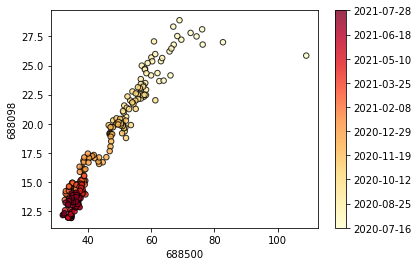

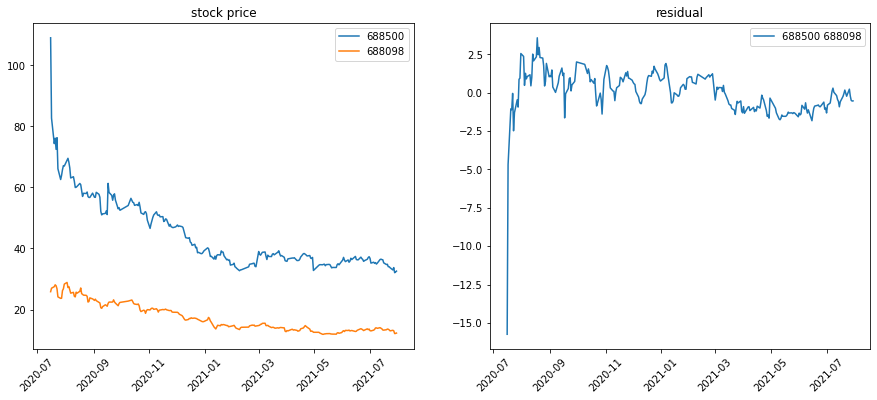

688500
                   129           208
code            688098        688500
name              申联生物          慧辰股份
industry          医疗保健          信息技术
cmv       2314032067.0  1100791842.0
mv        3605454320.0  1964560790.0
pe              27.838        26.656
csc          263557183      41617839


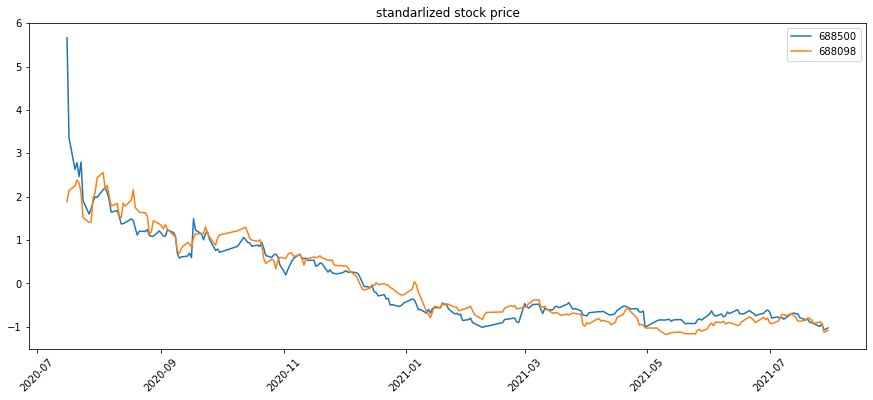

In [20]:
'''展示搜索出来的协整关系中688500和688098的相关信息'''
modeltrain1=coin_viewer('688500','688098',train_data,info)

~~策略函数怎么写呢？
策略函数，应该是一个类，写不同的策略时继承这个类，策略类应该包含计算信号的方法。输出交易信号是策略函数的最主要目的。目前策略和代码框架简单，策略类只包含两个方法：
func1:计算ratio，intercept
func2:更具输入的行情计算信号~~

In [46]:
'''定义策略类，包含方法1：初始化时计算比率和截距；方法2：根据输入的行情计算信号'''

class PairTrading():
    '''
    PairTrading类利用最简单的OLS计算配对交易比率和截距，并在回测阶段根据行情计算残差，并根据观测到残差的偏离程度计算交易信号。
    
    属性：
    -- x：在训练阶段作为自变量的价格序列
    -- y：在训练阶段作为因变量的价格序列
    -- model：用OLS拟合的线性模型
    -- ratio：配对交易的比率
    -- intercept：配对交易的截距
    -- resid：模型的残差序列
    -- standdev：模型残差的标准差
    方法：
    -- 初始化方法：初始化类PairTrading，在初始化时完成训练数据的拟合，计算出两只股票的配对交易比率、截距和残差的标准差。
    -- calculate方法：根据输入的行情价格计算并返回交易信号，
    '''
    def __init__(self,train_data,xcode,ycode):
        '''
        初始化类PairTrading，计算OLS模型，计算相关属性。
        
        初始化需输入的参数：
        -- train_data： 训练时间区间内科创板股票价格数据
        -- xcode：作为自变量的股票代码
        -- ycode：作为因变量的股票代码
        '''
        t=min(len(train_data[xcode][train_data[xcode].notna()]),len(train_data[ycode][train_data[ycode].notna()]))
        self.x=train_data[xcode][-t::]
        self.y=train_data[ycode][-t::]
        X=sm.add_constant(self.x)
        self.model=sm.OLS(self.y,X).fit()
        self.ratio=self.model.params[1]
        self.intercept=self.model.params[0]
        self.resid=self.model.resid
        self.standdev=np.std(self.resid)

    def calculate(self,x_price,y_price,xcode,ycode,sig_factor,close_factor,position):
        '''
        根据行情计算交易信号，例如：如果观测到的残差大于1.96倍标准差时，做多x，做空y；当观测到的残差小于1.96倍的标准差时，做空y，做多x；
        当观测到的残差回落到正负0.38个标准差时，或残差变号时平仓。其他时间不进行交易。这里的1.96，0.38可以在参数中设置，来根据实际情况
        调整交易频率
        
        参数：
        -- x_price：股票x的价格序列
        -- y_price：股票y的价格序列
        -- x_code：股票x的代码
        -- y_code：股票y的代码
        -- sig_factor：作为开仓阈值的z值，当设置为1.96时，残差绝对值大于1.96倍标准差开仓
        -- close_factor：作为平仓阈值的z值，当设置为0.38时，残差绝对值小雨0.38倍标准差时平仓
        -- position：投资者当前的仓位
        返回值：
        -- dict{xcode：股票x的代码,ycode：股票y的代码,ratio：交易的比率,resid：观测到的残差,threshold：开仓交易的阈值}，这个dict将
           作为交易信号signal被Agent类使用
        
        '''
        if (x_price*self.ratio+self.intercept-y_price)>sig_factor*self.standdev:
            return {xcode:'s',ycode:'b','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        elif (y_price-x_price*self.ratio-self.intercept)>sig_factor*self.standdev:
            return {xcode:'b',ycode:'s','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        elif np.abs(y_price-x_price*self.ratio-self.intercept)<close_factor*self.standdev:
            return {xcode:'c',ycode:'c','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        elif (position[xcode]>0) and (y_price<(x_price*self.ratio-self.intercept)):
            return {xcode:'c',ycode:'c','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        elif (position[ycode]>0) and (y_price>(x_price*self.ratio-self.intercept)):
            return {xcode:'c',ycode:'c','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        else:
            return {xcode:'h',ycode:'h','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        


In [138]:
'''定义一个agent'''
class Agent():
    '''
    Agent类初始化一个配对交易的初始资金，并根据交易信号和当前的仓位进行交易
    
    属性：
    -- cash：现金头寸
    -- position_list：持仓的股票列表
    -- position：当前的持仓
    -- wealth：当前的账户余额，为当前现金余额加上证券余额
    方法：
    -- 初始化方法： 初始化Agent的各个属性
    -- trade（）：根据交易信号进行交易，并返回当天的具体交易操作
    -- get_wealth（）：根据行情计算当前的账户余额
    '''
    def __init__(self,money,position_list):
        '''
        初始化Agent类
        
        参数：
        --money：初始资金
        --position_list：配对交易的两只股票列表
        '''
        self.cash=money
        self.position_list=position_list
        self.position=dict((k,0)for k in position_list)
        self.wealth=money
    def trade(self,signal,xcode,ycode,price,invest):
        '''
        根据交易信号完成交易行为，在开仓时判断是否超过持仓限制。
        
        参数：
        -- signal：接收到的交易信号{xcode：股票x的代码,ycode：股票y的代码,ratio：交易的比率,resid：观测到的残差,
                  threshold：开仓交易的阈值}
        -- xcode：x的股票代码
        -- ycode：y的股票代码
        -- price：股票的行情，即收盘价
        -- invest：本次交易投入的头寸
        返回值：
        -- 返回描述本次交易的一条记录
        '''
        # if invest<= price[xcode]*signal['ratio']:
        #     return 'the trade cannot be excuted'
        if signal[xcode]=='b':
            '''x b; y s'''
            '''long x'''
            x_volume=np.floor(invest/price[xcode])
            '''判断有没有超过持仓上限'''
            if ((self.position[xcode]+x_volume)> info[info['code']==xcode]['csc'].values*0.5) or (np.abs(self.position[ycode]-(np.floor(x_volume/signal['ratio'])))>info[info['code']==ycode]['csc'].values*0.1):
                x_volume=0
            '''判断结束'''
            cost=x_volume*price[xcode]
            self.position[xcode]=self.position[xcode]+x_volume
            self.cash=self.cash-cost
            '''short y'''
            y_volume=np.floor(x_volume/signal['ratio'])                    
            self.position[ycode]=self.position[ycode]-y_volume
            earn=y_volume*price[ycode]
            self.cash=self.cash+earn
            '''summary'''
            # print('buy ',x_volume,' ',xcode,'with cost ',cost)
            # print('short ',y_volume,' ',ycode,'with earn ',earn)
            return 'buy '+str(x_volume)+' '+xcode+'with cost '+str(cost)+\
                   'short '+str(y_volume)+' '+ycode+'with earn '+str(earn)+' total:'+str(earn-cost)
        elif signal[ycode]=='b':
            '''y b; x s'''
            '''long y'''
            y_volume=np.floor(invest/price[ycode])
            '''判断有没有超过持仓上限'''           
            if ((self.position[ycode]+y_volume)> info[info['code']==ycode]['csc'].values*0.5) or (np.abs(self.position[xcode]-(np.floor(y_volume*signal['ratio'])))>info[info['code']==xcode]['csc'].values*0.1):
                y_volume=0
            '''判断结束'''
            cost=y_volume*price[ycode]
            self.position[ycode]=self.position[ycode]+y_volume
            self.cash=self.cash-cost
            '''short x'''
            x_volume=np.floor(y_volume*signal['ratio'])                    
            self.position[xcode]=self.position[xcode]-x_volume
            earn=x_volume*price[xcode]
            self.cash=self.cash+earn
            '''summary'''
            # print('buy ',y_volume,' ',ycode,'with cost ',cost)
            # print('short ',x_volume,' ',xcode,'with earn ',earn)
            return 'short '+str(x_volume)+' '+xcode+'with earn '+str(cost)+\
                   'buy '+str(y_volume)+' '+ycode+'with cost '+str(earn)+' total:'+str(earn-cost)
        elif signal[xcode]=='c' and signal[ycode]=='c':
            total_change=0
            for stock in self.position_list:
                change=self.position[stock]*price[stock]               
                total_change+=change
                self.cash=self.cash+change
                # print('close ',stock,'with change ',change)
                self.position[stock]=0
            return 'close with change:'+str(total_change)
        else:
            # print('hold steady')
            return 'hold steady'
    def get_wealth(self,price):
        '''
        根据价格行情计算当前的账户余额
        
        参数：
        -- price：股票价格行情
        '''
        security_value=0
        for stock in self.position_list:
            security_value+=self.position[stock]*price[stock]
        self.wealth=self.cash+security_value
        return self.wealth
        

In [242]:
'''定义回测方法'''
def back_test(xcode,ycode,startdate,data,agent,strategy,open_factor,close_factor):
    '''
    调用PairTrading和Agent进行回测，并将每日的仓位信息和交易细节保存
    
    参数：
    -- xcode，ycode：股票x，y的代码
    -- startdate：回测的开始时间
    -- data：科创板价格数据文件
    -- agent：交易主体，Agent对象
    -- strategy：策略，PairTrading对象或kalman策略
    -- open_factor：设置为开仓阈值的Z值，1.96
    -- close_factor：设置为平仓阈值的Z值
    返回值：
    -- record：该股票对的配对交易记录
    '''
    x_sequence=data[xcode][data.index > startdate]
    y_sequence=data[ycode][data.index > startdate]
    record=pd.DataFrame(columns=['date','cash',xcode+'_P',xcode+'price',ycode+'_P',ycode+'price','wealth','resid',
                                 'open_threshold','close_threshold','signal','action'])
    for date in x_sequence.index:
        # print(date)
        x_price=x_sequence[x_sequence.index==date].values[0]
        y_price=y_sequence[y_sequence.index==date].values[0]
        test_price={xcode:x_price,ycode:y_price}
        signal=strategy.calculate(x_price,y_price,xcode,ycode,open_factor,close_factor,agent.position)
        # print(signal)
        trader=agent.trade(signal,xcode,ycode,test_price,(0.8*agent.cash))
        # print(trader)
        record=record.append({'date':date,'cash':agent.cash,xcode+'_P':agent.position[xcode],xcode+'price':x_price,
                              ycode+'_P':agent.position[ycode],ycode+'price':y_price,'wealth':agent.get_wealth(test_price),
                             'resid':signal['resid'],'open_threshold':open_factor*strategy.standdev,
                              'close_threshold':close_factor*strategy.standdev,'signal':signal,'action':trader},
                             ignore_index=True)
    '''最后一天平仓'''
    close_signal={xcode: 'c', ycode: 'c', 'ratio': 0}
    trader=agent.trade(close_signal,xcode,ycode,test_price,(0.8*agent.cash))
    record=record.append({'date':date,'cash':agent.cash,xcode+'_P':agent.position[xcode],xcode+'price':x_price,
                              ycode+'_P':agent.position[ycode],ycode+'price':y_price,'wealth':agent.get_wealth(test_price),
                             'resid':signal['resid'],'open_threshold':open_factor*strategy.standdev,
                              'close_threshold':close_factor*strategy.standdev,'signal':close_signal,'action':'close'},
                             ignore_index=True)
    # record.to_csv(xcode+'Kalmanpair'+ycode+'.csv')
    # print(trader)
    return record
        

In [143]:
'''交易测试1:准备回测的参数'688500','688098'''
startdate='2021-07-31'
tradebot1=PairTrading(train_data,'688500','688098')
xcode='688500'
ycode='688098'
plist=['688500','688098']
aman = Agent(10000,plist)

In [144]:
trade_record=back_test('688500','688098',startdate,data,aman,tradebot1,1.96,0.38)

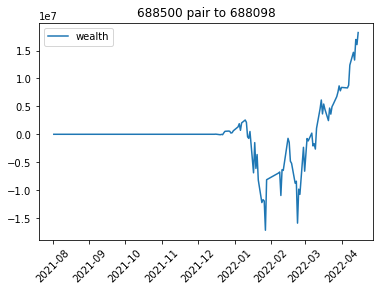

18219666.650000006
{'688500': 0, '688098': 0}
ratio: 0.3764347637156057 intercept: 0.5605045482594363 stdev: 1.5036000271422085


In [169]:
plt.plot(trade_record['date'],trade_record['wealth'])
plt.legend(['wealth'])
plt.xticks(rotation=45)
plt.title(xcode+' pair to '+ycode)
plt.show()
print(aman.wealth)
print(aman.position)
print('ratio:',tradebot1.ratio,'intercept:',tradebot1.intercept,'stdev:',tradebot1.standdev)

由于交易假设不考虑融券和买入时的流动性问题，且持仓和融券卖出的限制极为宽松，同时在交易环节没有设置止损等退出行为，配对交易金额会逐渐增大。可能出现大额回撤，大额收益或大额亏损的情况。

In [42]:
'''交易测试2:准备回测的参数'688379','688168'''
startdate='2021-07-31'
tradebot3=PairTrading(train_data,'688379','688168')
plist=['688379','688168']
aman = Agent(10000,plist)
trade_record=back_test('688379','688168',startdate,data,aman,tradebot3,1.96,0.38)

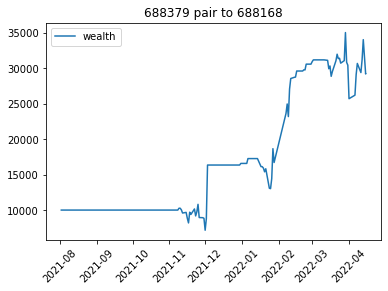

In [44]:
plt.plot(trade_record['date'],trade_record['wealth'])
plt.legend(['wealth'])
plt.xticks(rotation=45)
plt.title(plist[0]+' pair to '+plist[1])
plt.show()

In [ ]:
测试中利用688379和688168进行配对交易，账户余额从初始的10000元，逐渐累积到29177

In [151]:
''' 大规模测试 ,得到当前每个协整对当前策略的收益'''

def massive_test(coin_list,train_data,data,init_capital,sig_factor,close_factor):
    '''
    便利之前协整搜索结果的每一条记录，调用back_test方法进行回测。记录每一个协整股票对配对交易的回测结果。
    
    参数：
    -- coin_list：协整股票对的搜索结果
    -- train_data：训练阶段股票价格数据
    -- data：股票价格数据
    -- init_capital：大规模回测给每个协整对的初始资金
    -- sig_factor：开仓阈值的z值
    -- close_factor：平仓阈值的z值
    返回值：
    -- dataframe 在原有coin_list基础上，新增每个协整对的回测情况
    '''
    startdate='2021-07-31'
    coin_list['wealth']=0
    coin_list['rate']=0
    coin_list['id']=range(len(coin_list))
    for i,r in coin_list.iterrows():
        xcode=r['x']
        ycode=r['y']
        print(i,xcode,ycode)
        tradebot_mass=PairTrading(train_data,xcode,ycode)
        # print(tradebot_mass.standdev)
        plist=[xcode,ycode]
        # print(plist)
        investor = Agent(init_capital,plist)
        # print('aman:',investor.cash)
        # print(investor)
        trade_record=back_test(xcode,ycode,startdate,data,investor,tradebot_mass,sig_factor,close_factor)
        # print(investor.wealth)
        coin_list.loc[coin_list['id']==r['id'],'wealth']=investor.wealth
        coin_list.loc[coin_list['id']==r['id'],'rate']=investor.wealth/init_capital-1
    print('massive test done')
    coin_list.to_csv('PairTrade.csv')
    return coin_list
    

   

In [ ]:
test_list=massive_test(coin_list,train_data,data,10000,1.96,0.38)

**大规模回测的结果：**    
1. 在训练阶段搜索出的协整对共有9037组，在回测时中有5373组实现了收益占58.79%；有3133组出现亏损占34.66%；有592组在当前设置的阈值范围内没有交易记录，占6.55%
2. 9037组协整对，每组初始资金为10000元，全市场共配置初始资金9037万元。回测结束全市场总余额为21550760万元。共盈利21541722万元。回测巨额盈利是由于在实际中融券券源难以模拟，所以没有进行限制，所以只要没有超过融券数量超过流通股本的10%，策略就可以一直运行，导致了巨额收益。


~~除了最初步的配对交易之外，可以尝试  
1、缩短计算协整的时间，只计算最近1个月交易日的协整关系，并根据一个月的动态窗口，在每日交易后将当天信息加入窗口，计算最新的对冲比率。 
2、利用kalman滤波器更新对冲比率等交易参数  
同时考虑以上算法的问题：
1、最大可融券卖出的数量，不能无限融券，可以参考流通股本，或者预设几个数字
1、融券的利息。   
2、融券的时间到期和归还。  
3、交易失败的情况

# 第三部分：利用卡尔曼滤波器实现动态比率的配对交易

* **为什么引入卡尔曼滤波器**  
由于回测时期市场风格和训练时间可能存在较大差异，在训练时起计算出的配对交易比率和截距可能在回测时难以适应真实情况。所以需要建立动态系统，来根据股票价格的变动动态更新配对交易比率和截距。所以对第二部分的配对交易策略进行了修改，利用卡尔曼滤波器动态更新交易比率和截距以及标准差，以提高配对交易策略的表现。   
* **具体操作**   
卡尔曼滤波器作为数据融合思想在工程科学中的一个简单应用，原理和应用相对直观。这里将股票交易对中OLS的斜率和截距作为状态变量，在策略初始化时进行拟合计算，之后在每次导入新的价格行情计算交易信号时，利用新的行情价格对状态值进行更新，得到新的配对交易比率和截距。并根据当前对冲比率和截距的估计的协方差矩阵，计算出当前估计下残差的标准差。结合该标准差和观测到的残差计算交易信号。

In [49]:
''' 利用卡尔曼滤波进行配对交易的策略 '''
class KalmanTrading():
    '''
    KalmanTrading类利用卡尔曼滤波器计算动态交易比率和截距，并在回测阶段根据行情更新交易比率和截距，并根据协方差矩阵计算出的标准差计算交易信号。
    
    属性：
    -- x：在训练阶段作为自变量的价格序列
    -- y：在训练阶段作为因变量的价格序列
    -- trans_cov：初始的模型预测部分的协方差矩阵
    -- obs_mat：由于斜率和截距为状态变量，作为自变量x的股票价格需要转化成模型的观测部分的系数矩阵
    -- kf：卡尔曼滤波器
    -- state_means： 训练阶段状态变量的值
    -- state_covs：训练阶段状态变量的协方差矩阵
    -- current_state_means：保存最新的状态变量的取值，会随着交易动态更新
    -- current_state_covs：保存最新的状态变量的协方差，会随着交易动态更新
    -- ratio：配对交易的比率
    -- intercept：配对交易的截距
    -- resid：模型的残差序列
    -- train_standdev：训练阶段残差的标准差
    -- standdev：残差的标准差的估计，会随着交易动态更新，保存最新的值

    方法：
    -- 初始化方法：初始化类KalmanTrading，在初始化时完成训练阶段卡尔曼滤波的计算，计算出两只股票的配对交易比率、截距和残差的标准差。
    -- calculate方法：根据输入的行情价格通过卡尔曼滤波器对配对交易比率和截距进行更新，同时根据最新的协方差矩阵计算残差标准差的估计，并返回交
       易信号。
    '''
    def __init__(self,train_data,xcode,ycode):
        '''
        初始化KalmanTrading
        
        参数：
        -- train_data: 训练阶段的股票价格数据
        -- xcode，ycode：股票代码
        '''
        t=min(len(train_data[xcode][train_data[xcode].notna()]),len(train_data[ycode][train_data[ycode].notna()]))
        self.x=train_data[xcode][-t::]
        self.y=train_data[ycode][-t::]
        '''以下为kalman滤波过程'''
        delta = 1e-5
        self.trans_cov = delta / (1 - delta) * np.eye(2)
        self.obs_mat = np.vstack([self.x, np.ones(self.x.shape)]).T[:, np.newaxis]
        self.kf = KalmanFilter(
            n_dim_obs=1, 
            n_dim_state=2,
            initial_state_mean=np.zeros(2),
            initial_state_covariance=np.ones((2, 2)),
            transition_matrices=np.eye(2),
            observation_matrices=self.obs_mat,
            observation_covariance=1.0,
            transition_covariance=self.trans_cov)
        self.state_means, self.state_covs = self.kf.filter(self.y.values)
        self.current_state_means=self.state_means[-1]
        self.current_state_covs=self.state_covs[-1]
        self.ratio=self.current_state_means[0]
        self.intercept=self.current_state_means[1]
        '''计算residual，进而得到residual的标准差'''
        self.resid=self.y-self.x*self.ratio-self.intercept
        self.train_standdev=np.std(self.resid)
        self.standdev=self.train_standdev
        
    def calculate(self,x_price,y_price,xcode,ycode,sig_factor,close_factor,position):
        '''
        根据最新的行情通过卡尔曼滤波器更新比率和截距，并通过计算更新标准差，再计算交易信号。
        
        参数：
        -- x_price：股票x的价格序列
        -- y_price：股票y的价格序列
        -- x_code：股票x的代码
        -- y_code：股票y的代码
        -- sig_factor：作为开仓阈值的z值，当设置为1.96时，残差绝对值大于1.96倍标准差开仓
        -- close_factor：作为平仓阈值的z值，当设置为0.38时，残差绝对值小雨0.38倍标准差时平仓
        -- position：投资者当前的仓位
        返回值：
        -- dict{xcode：股票x的代码,ycode：股票y的代码,ratio：交易的比率,resid：观测到的残差,threshold：开仓交易的阈值}，这个dict将
           作为交易信号signal被Agent类使用
        '''
        '''首先进行kalman fillter的更新'''
        self.current_state_means,self.current_state_covs=self.kf.filter_update(self.current_state_means, 
                                            self.current_state_covs, 
                                            observation=y_price, 
                                            observation_matrix=np.array([[x_price,1]]))
        self.ratio=self.current_state_means[0]
        self.intercept=self.current_state_means[1]
        
        '''动态标准差'''
        var=x_price**2*self.current_state_covs[0,0]+self.current_state_covs[1,1]+2*x_price*self.current_state_covs[0,1]
        self.standdev=np.sqrt(var)
        '''根据最新的ratio和intercept计算signal'''
        if (x_price*self.ratio+self.intercept-y_price)>sig_factor*self.standdev:
            return {xcode:'s',ycode:'b','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        elif (y_price-x_price*self.ratio-self.intercept)>sig_factor*self.standdev:
            return {xcode:'b',ycode:'s','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        elif np.abs(y_price-x_price*self.ratio-self.intercept)<close_factor*self.standdev:
            return {xcode:'c',ycode:'c','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        elif (position[xcode]>0) and (y_price<(x_price*self.ratio-self.intercept)):
            return {xcode:'c',ycode:'c','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        elif (position[ycode]>0) and (y_price>(x_price*self.ratio-self.intercept)):
            return {xcode:'c',ycode:'c','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        else:
            return {xcode:'h',ycode:'h','ratio':self.ratio,'resid':(y_price-x_price*self.ratio-self.intercept),'threshold':sig_factor*self.standdev}
        

        


In [237]:
'''kalman交易测试 :参数'688500','688098'''
startdate='2021-07-31'
xcode='688500'
ycode='688098'
plist=['688500','688098']
bman = Agent(10000,plist)
test_kalman=KalmanTrading(train_data,'688500','688098')
kalman_trade_record=back_test('688500','688098',startdate,data,bman,test_kalman,1.96,0.38)

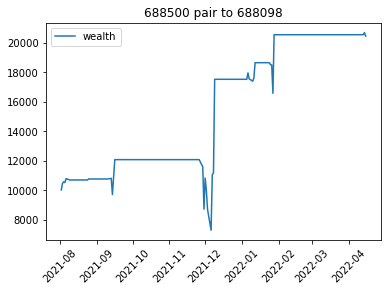

20435.95000000004
{'688500': 0, '688098': 0}


In [238]:
plt.plot(kalman_trade_record['date'],kalman_trade_record['wealth'])
plt.legend(['wealth'])
plt.xticks(rotation=45)
plt.title(xcode+' pair to '+ycode)
plt.show()
print(bman.wealth)
print(bman.position)
# print('ratio:',tradebot1.ratio,'intercept:',tradebot1.intercept,'stdev:',tradebot1.standdev)

对比之前简单配对交易策略中，688500和688098的交易情况，可以看到KalmanTrading的回测结果更优秀，风险更小，而且回测过程中的回撤更小。

In [241]:
'''卡尔曼滤波的大规模测试'''

def kalman_massive_test(coin_list,train_data,data,init_capital,sig_factor,close_factor):
    startdate='2021-07-31'
    coin_list['wealth']=0
    coin_list['rate']=0
    coin_list['id']=range(len(coin_list))
    for i,r in coin_list.iterrows():
        xcode=r['x']
        ycode=r['y']
        print(i,xcode,ycode)
        tradebot_mass=KalmanTrading(train_data,xcode,ycode)
        # print(tradebot_mass.standdev)
        plist=[xcode,ycode]
        # print(plist)
        investor = Agent(init_capital,plist)
        # print('aman:',investor.cash)
        # print(investor)
        trade_record=back_test(xcode,ycode,startdate,data,investor,tradebot_mass,sig_factor,close_factor)
        # print(investor.wealth)
        coin_list.loc[coin_list['id']==r['id'],'wealth']=investor.wealth
        coin_list.loc[coin_list['id']==r['id'],'rate']=investor.wealth/init_capital-1
    print('massive test done')
    coin_list.to_csv('KalmanPairTrade.csv')
    return coin_list
    

   

In [ ]:
test_list=kalman_massive_test(coin_list,train_data,data,10000,1.96,0.38)

**KalmanTrading大规模回测的结果：**    
1. 在训练阶段搜索出的协整对共有9037组，在回测时中有5849组实现了收益占64.72%（常规配对交易58.79%）；有2947组出现亏损占32.61%（常规配对交易占34.66%）；有242组在当前设置的阈值范围内没有交易记录，占2.68%。可以看出利用卡尔曼滤波器进行动态配对交易盈利能力有显著提升。
2. 9037组协整对，每组初始资金为10000元，全市场共配置初始资金9037万元。回测结束全市场总余额为3872784万元。共盈利3863746万元。盈利数字较简单配对减小，但此比较由于上文提到的原因参考价值较小。
